In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

# Tổng quan về tập dữ liệu

In [2]:
df = pd.read_csv("/kaggle/input/emotions-in-text/Emotion_final.csv")
df.head()

Text  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB


<Axes: xlabel='Emotion', ylabel='count'>

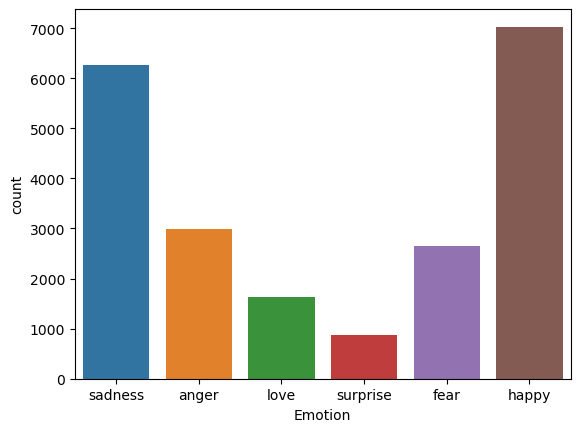

In [4]:
sns.countplot(x="Emotion", data=df)

# Tiền xử lý dữ liệu

* ### Chuyển tất cả về chữ thường

In [5]:
#ex: "I'm feeling grouchy!"
# => "i'm feeling grouchy!"
df["Text"] = df["Text"].str.lower()
df[['Text', 'Emotion']].head()

Text  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

* ### Loại bỏ dấu câu

In [6]:
#ex: "i'm feeling grouchy!"
# => "im feeling grouchy"
def remove_punctuation(text):
  return re.sub(r'[^\w\s]', '', text)

df["Text"] = df["Text"].apply(lambda text: remove_punctuation(text))
df[['Text', 'Emotion']].head()

Text  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

* ### Loại bỏ từ dừng

In [7]:
#ex: "i feel romantic too"
# => "feel romantic"
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
", ".join(stopwords.words('english'))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["Text"] = df["Text"].apply(lambda text: remove_stopwords(text))
df[['Text', 'Emotion']].head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text  Emotion
0                              didnt feel humiliated  sadness
1  go feeling hopeless damned hopeful around some...  sadness
2          im grabbing minute post feel greedy wrong    anger
3  ever feeling nostalgic fireplace know still pr...     love
4                                    feeling grouchy    anger

* ### Rút gọn từ về từ gốc

In [8]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [9]:
from nltk.stem import WordNetLemmatizer

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join(list([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]))

df['Text'] = df["Text"].apply(lemmatize_text)
df[['Text', 'Emotion']].head()

Text  Emotion
0                              didnt feel humiliated  sadness
1  go feeling hopeless damned hopeful around some...  sadness
2          im grabbing minute post feel greedy wrong    anger
3  ever feeling nostalgic fireplace know still pr...     love
4                                    feeling grouchy    anger

* ### Loại bỏ các từ thường xuyên xuất hiện và hiếm khi xuất hiện không mang ý nghĩa phân loại

In [10]:
#ex: "im feel grouchy"
# => "grouchy"
from collections import Counter
cnt = Counter()
for text in df["Text"].values:
    for word in text.split():
        cnt[word] += 1

FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["Text"] = df["Text"].apply(lambda text: remove_freqwords(text))

# removal of rare words
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])
df["Text"] = df["Text"].apply(lambda text: remove_rarewords(text))
df[['Text', 'Emotion']].head()

Text  Emotion
0                                   didnt humiliated  sadness
1  go hopeless damned hopeful around someone care...  sadness
2                  grabbing minute post greedy wrong    anger
3            ever nostalgic fireplace still property     love
4                                            grouchy    anger

* ### Vector hoá dữ liệu

In [11]:
# Using CountVectorizer
# ex: "one cent two cent old cent new cent all money"
# sparse vector: [[102, 1], [1991, 4], [985, 1], ...]
# 102 is value of "one" in vocabulary
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
features_1 = vectorizer.fit_transform(df["Text"])

print(np.shape(features_1))
print(len(vectorizer.vocabulary_))

(21459, 17132)
17132


In [12]:
# Using TfidfVectorizer
# ex: "become overwhelmed defeated"
# sparse vector: [[988, 0.152], [2615, 0.651], [6114, 0.823]]
# 988 is value of "become" in vocabulary
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
features_2 = vectorizer.fit_transform(df["Text"])

print(np.shape(features_2))
print(len(vectorizer.vocabulary_))

(21459, 17132)
17132


In [13]:
TfidfVocabulary = vectorizer.vocabulary_

* ### Mã hoá nhãn

In [14]:
# {"anger": 1, "fear": 2, "happy": 3, "love": 4, "sadness": 5, "surprise": 6}
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(np.array(df.Emotion).reshape(-1,1))

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


* ### Chia tập dữ liệu

In [15]:
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(features_1, y, test_size=0.1, stratify=y)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features_2, y, test_size=0.1, stratify=y)

print(X_train_1.shape)
print(X_train_2.shape)

(19313, 17132)
(19313, 17132)


# Phân tích dữ liệu

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

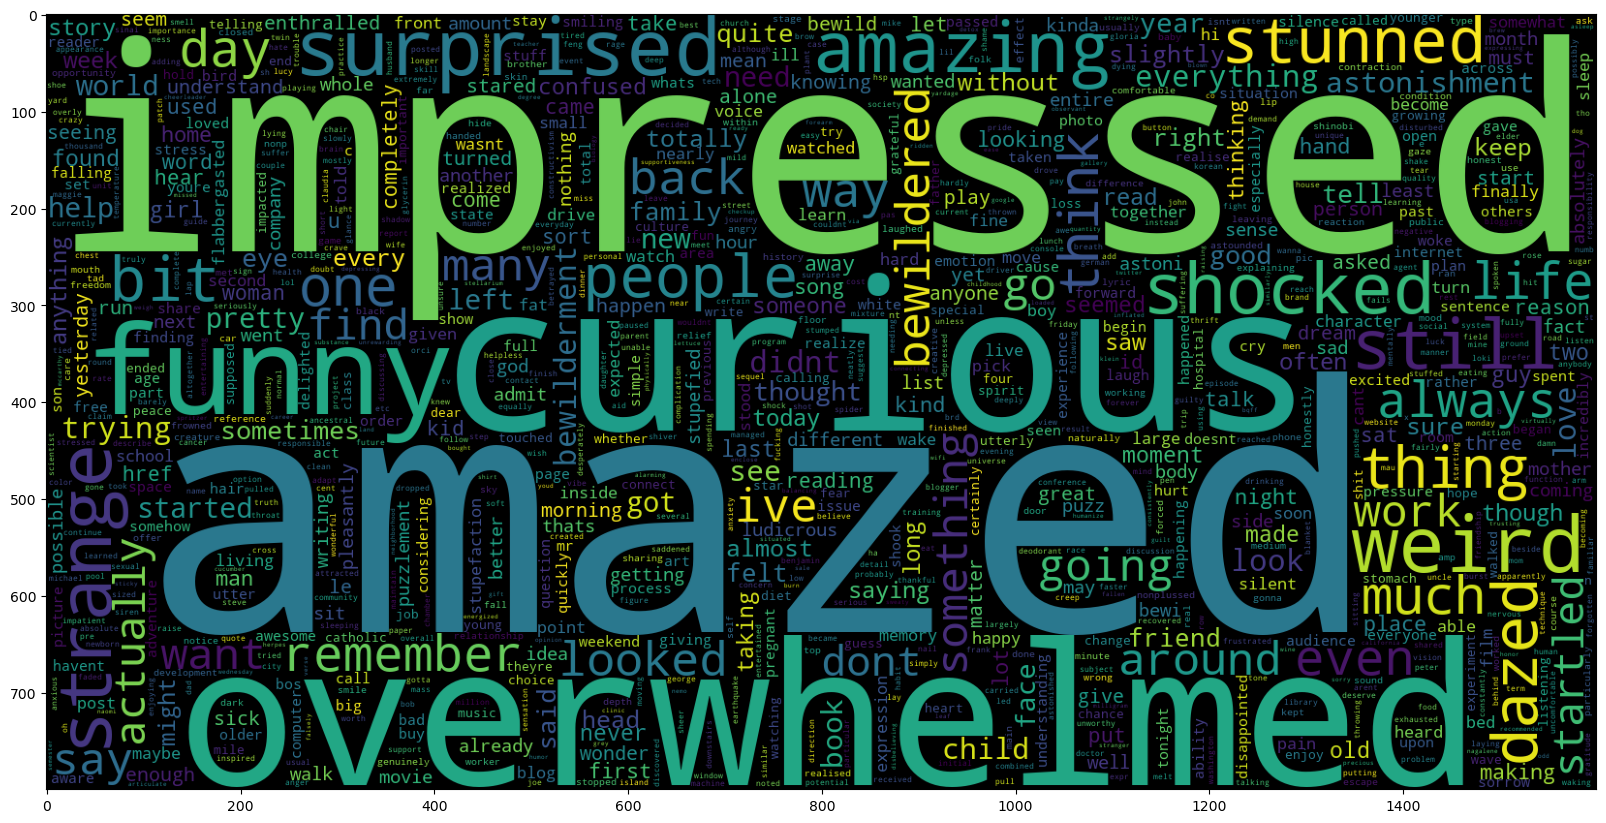

In [17]:
data_pos = df[df.Emotion == 'surprise']['Text'].astype(str)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

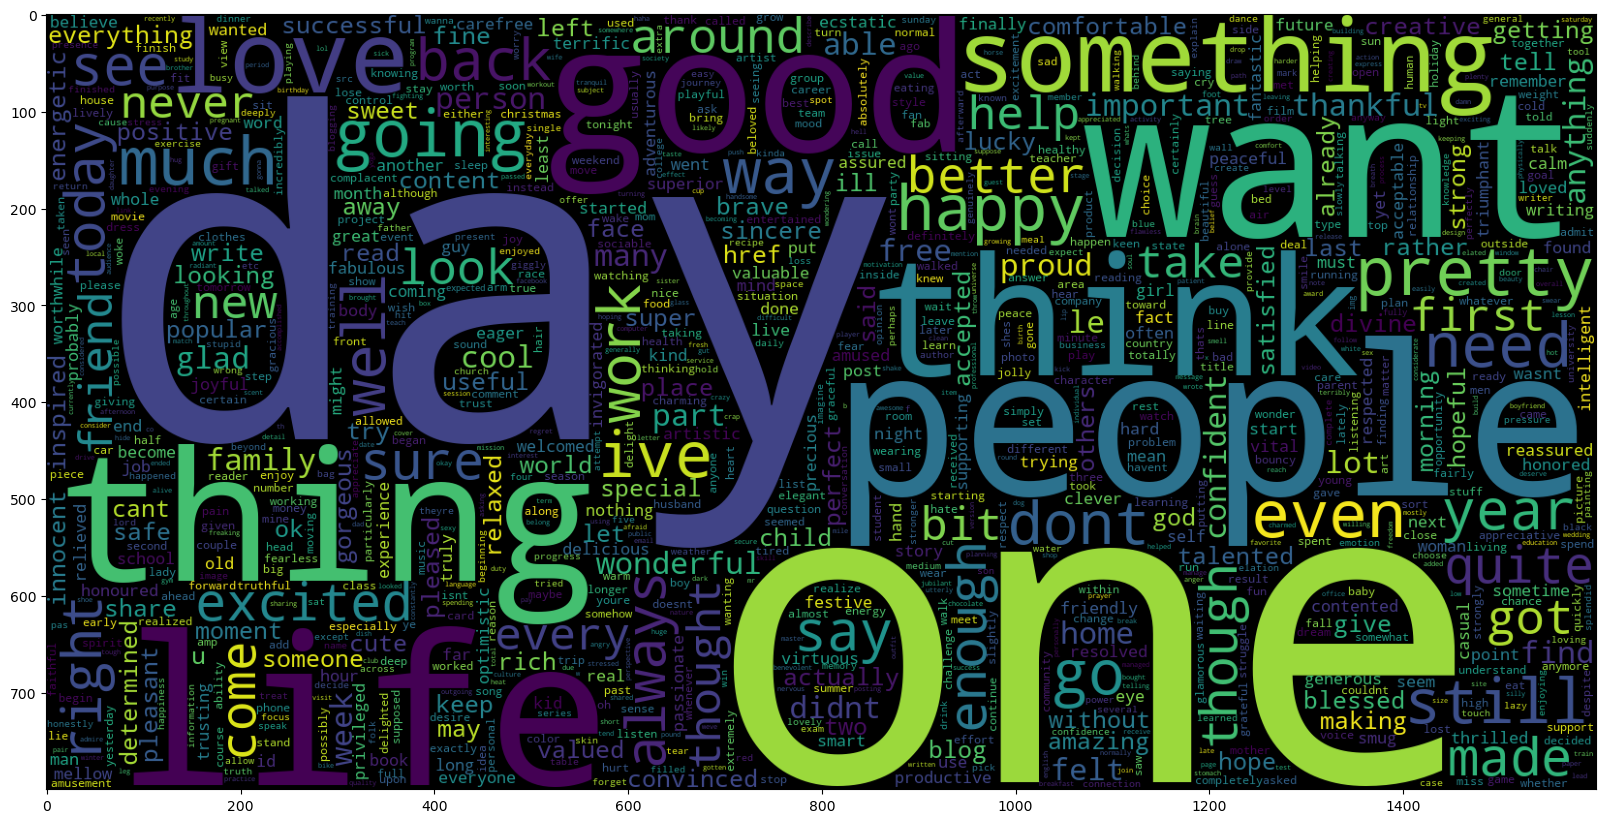

In [18]:
data_pos = df[df.Emotion == 'happy']['Text'].astype(str)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

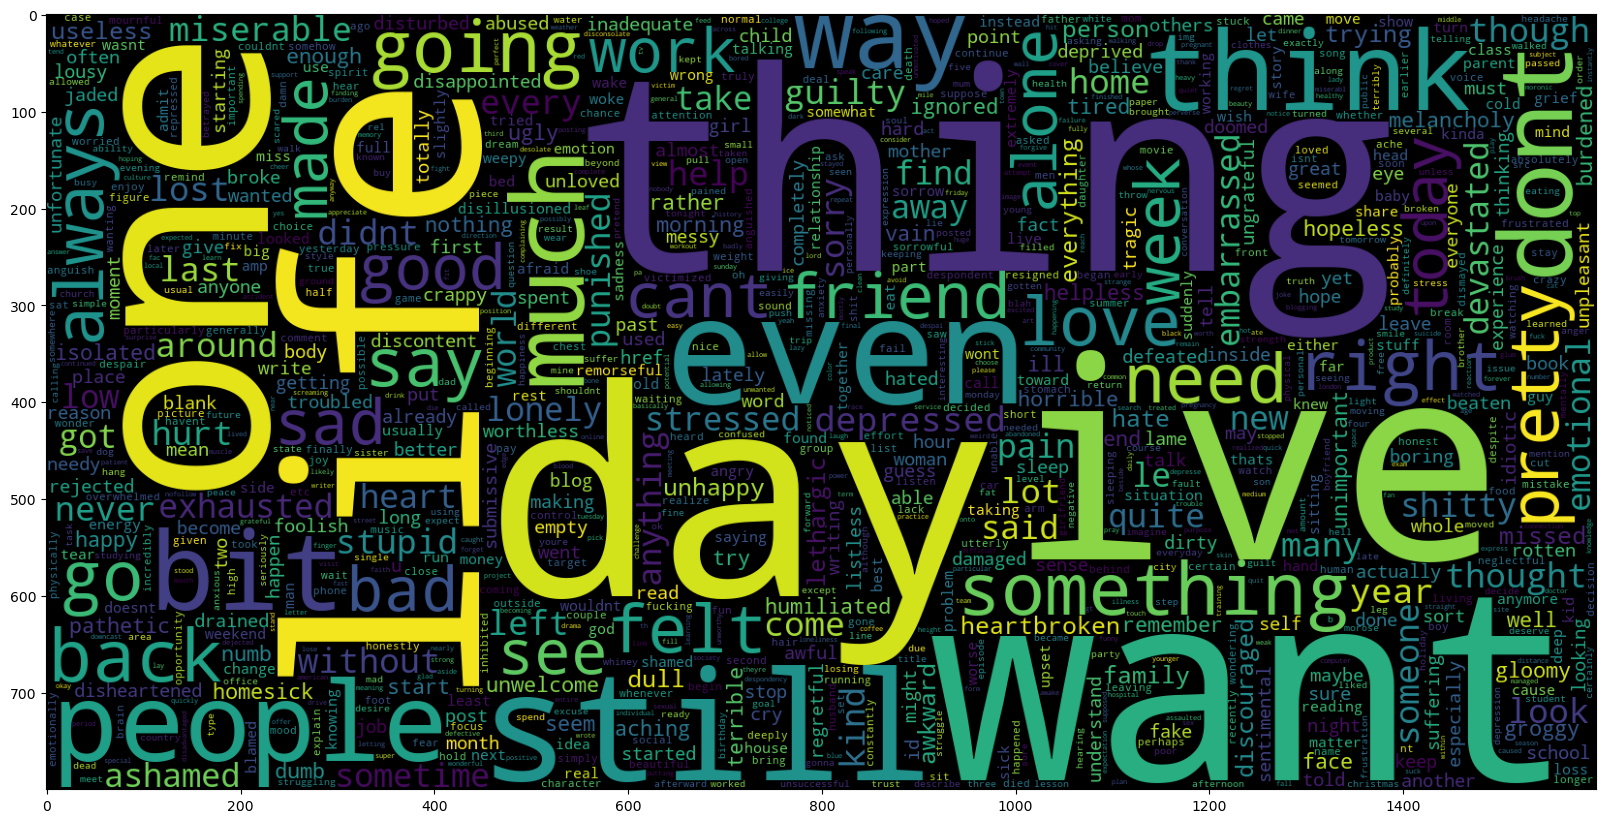

In [19]:
data_pos = df[df.Emotion == 'sadness']['Text'].astype(str)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

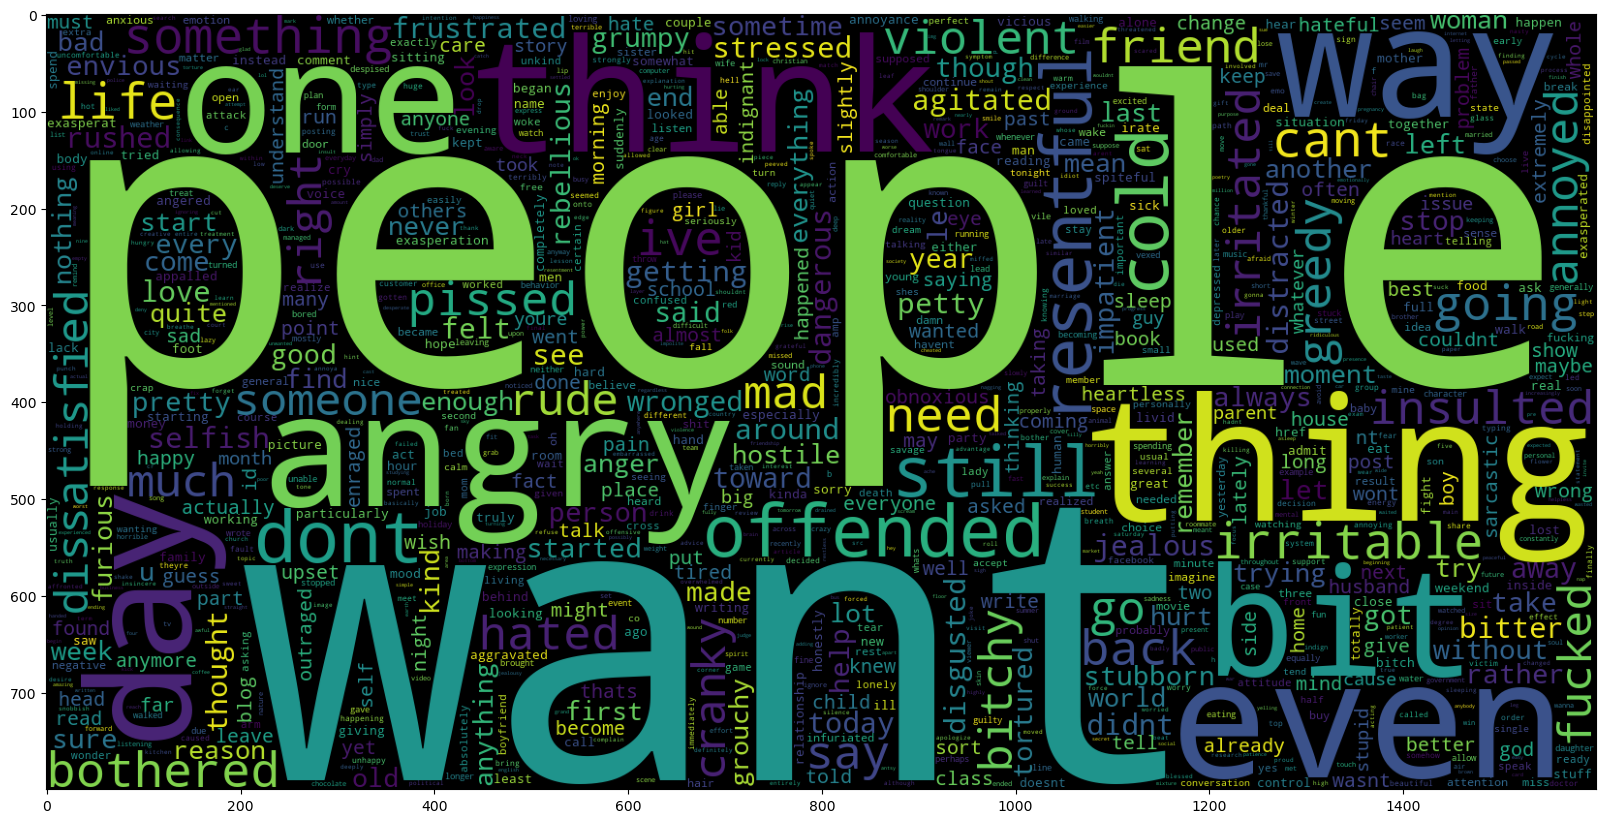

In [20]:
data_pos = df[df.Emotion == 'anger']['Text'].astype(str)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

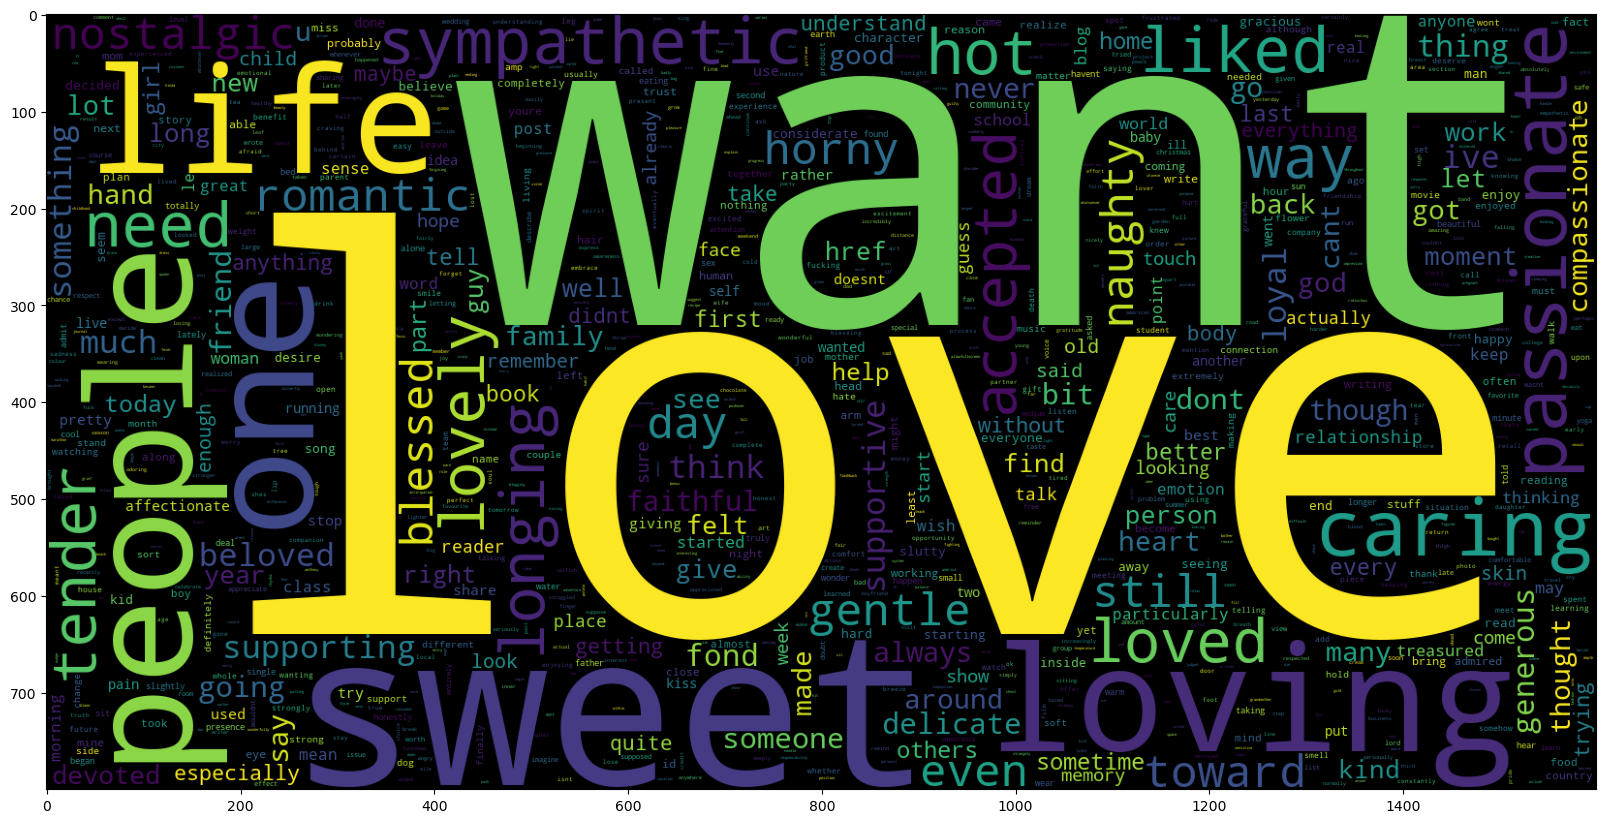

In [21]:
data_pos = df[df.Emotion == 'love']['Text'].astype(str)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

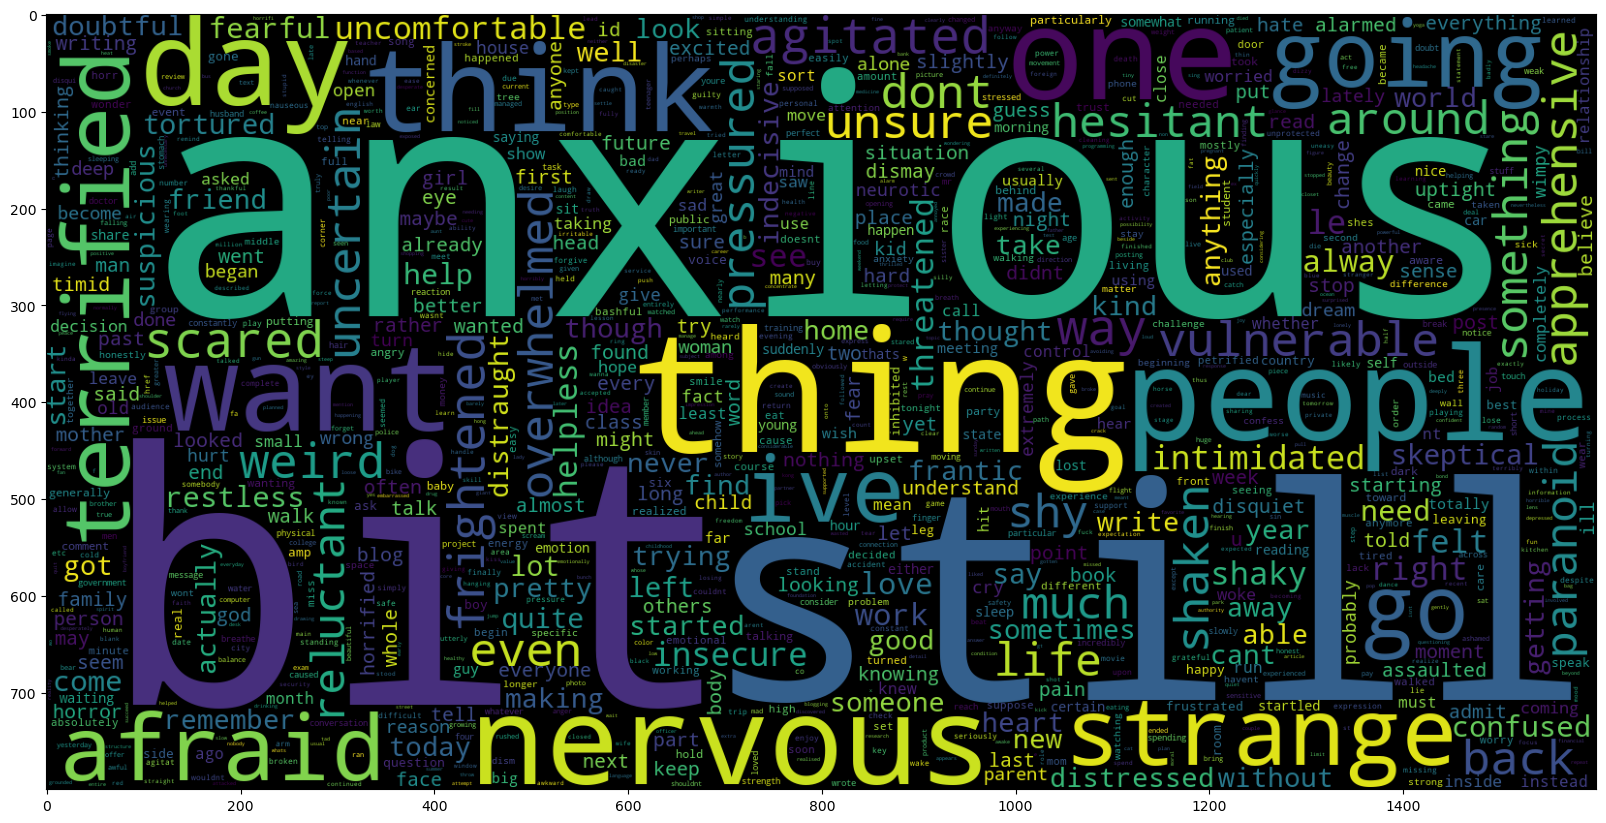

In [22]:
data_pos = df[df.Emotion == 'fear']['Text'].astype(str)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

# Huấn luyện mô hình

In [23]:
import time

## SVM

### SVM with Count Vectorizer and Tf-idf Vectorizer


In [24]:
# Soft Margin Suport Vector Machine
from sklearn.svm import SVC

# svm linear
classifier_svm_linear_1 = SVC(C = 1,kernel = 'linear')
t = time.time()
classifier_svm_linear_1.fit(X_train_1, y_train_1)
time_for_train_svm_linear_1 = time.time()-t
print(f'linear SVM Taken: {time_for_train_svm_linear_1} seconds')

classifier_svm_linear_2 = SVC(C = 1,kernel = 'linear')
t = time.time()
classifier_svm_linear_2.fit(X_train_2, y_train_2)
time_for_train_svm_linear_2 = time.time()-t
print(f'linear SVM Taken: {time_for_train_svm_linear_2} seconds')

linear SVM Taken: 18.669761657714844 seconds
linear SVM Taken: 27.183578968048096 seconds


### Thêm biến class weight để cân bằng trọng số giữa các lớp

In [25]:
from sklearn.utils.class_weight import compute_class_weight

# X_train: features, y_train: nhãn của dữ liệu huấn luyện
classes = np.unique(y_train_1)
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes= np.unique(y_train_1),
                                     y= y_train_1)

# In trọng số của từng lớp
for class_label, weight in zip(classes, class_weights):
    print(f"Class {class_label}: Weight {weight}")
class_weights = dict(zip(np.unique(y_train_1), class_weights))

Class 0: Weight 1.1948156396931453
Class 1: Weight 1.3484848484848484
Class 2: Weight 0.5088260090631257
Class 3: Weight 2.179304897314376
Class 4: Weight 0.5709175830672816
Class 5: Weight 4.069321533923304


In [26]:
from sklearn.svm import SVC

# svm linear using TfidfVectorizer with class weight
classifier_svm_linear_3 = SVC(C=1, kernel='linear', class_weight=class_weights)
t = time.time()
classifier_svm_linear_3.fit(X_train_2, y_train_2)
time_for_train_svm_linear_3 = time.time()-t
print(f'linear SVM Taken: {time_for_train_svm_linear_3} seconds')

linear SVM Taken: 30.456439971923828 seconds


# Đánh giá mô hình

In [28]:
# evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
class_names = ["anger", "fear", "happy", "love", "sadness", "surprise"]

def model_Evaluate(model, X_test, y_test):

  t = time.time()
  y_pred = model.predict(X_test)
  t = time.time() - t
  print(f'Prediction time: {t/len(y_pred)}')
  print(classification_report(y_test, y_pred))

  for title, normalize in titles_options:
      disp = ConfusionMatrixDisplay.from_predictions(
          y_test,
          y_pred,
          display_labels=class_names,
          cmap=plt.cm.Blues,
          normalize=normalize,
      )
      disp.ax_.set_title(title)
      plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
      plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)

## SVM

### SVM with Count Vectorizer


Prediction time: 0.0006711455226944411
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       299
           1       0.84      0.79      0.82       265
           2       0.89      0.90      0.89       703
           3       0.72      0.81      0.76       164
           4       0.91      0.90      0.90       627
           5       0.78      0.76      0.77        88

    accuracy                           0.87      2146
   macro avg       0.83      0.84      0.84      2146
weighted avg       0.87      0.87      0.87      2146



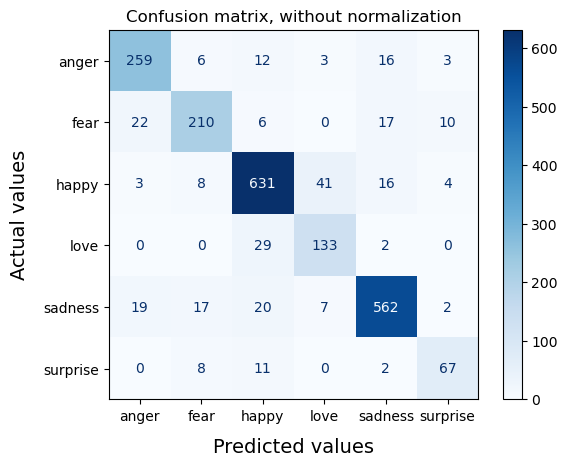

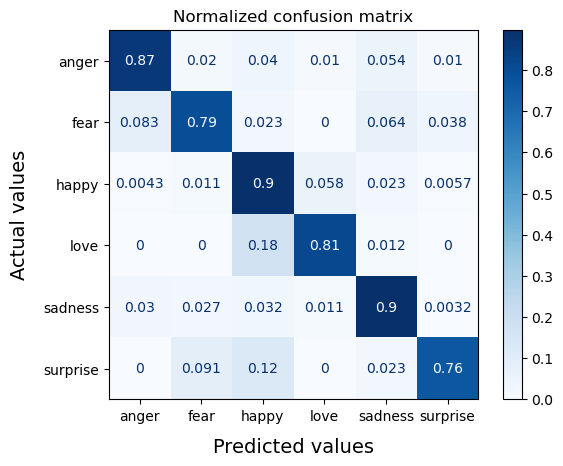

In [29]:
# Count Vectorizer
model_Evaluate(classifier_svm_linear_1, X_test_1, y_test_1)

### SVM with Tf-**idf** Vectorizer

Prediction time: 0.0007492451610014134
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       299
           1       0.83      0.84      0.83       265
           2       0.89      0.93      0.91       703
           3       0.80      0.80      0.80       164
           4       0.93      0.91      0.92       627
           5       0.73      0.69      0.71        88

    accuracy                           0.89      2146
   macro avg       0.85      0.84      0.85      2146
weighted avg       0.89      0.89      0.89      2146



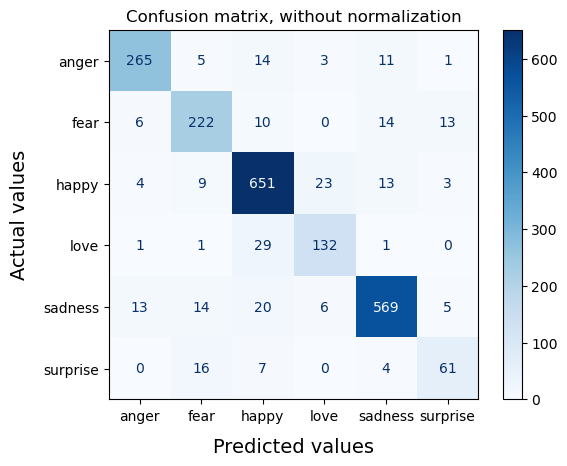

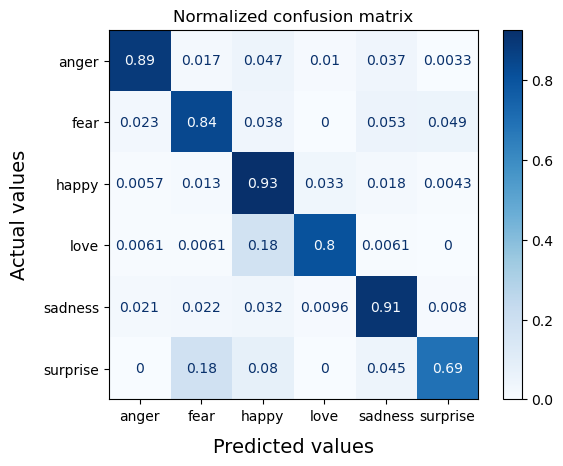

In [30]:
# Tfidf Vectorizer
model_Evaluate(classifier_svm_linear_2, X_test_2, y_test_2)

### SVM with Tf-idf vectorizer and class weigth

Prediction time: 0.0007706555049217203
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       299
           1       0.83      0.85      0.84       265
           2       0.92      0.86      0.89       703
           3       0.67      0.94      0.78       164
           4       0.95      0.88      0.91       627
           5       0.64      0.80      0.71        88

    accuracy                           0.87      2146
   macro avg       0.82      0.87      0.84      2146
weighted avg       0.89      0.87      0.88      2146



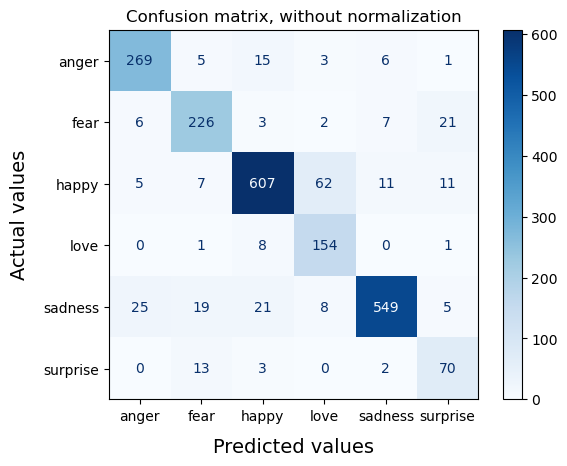

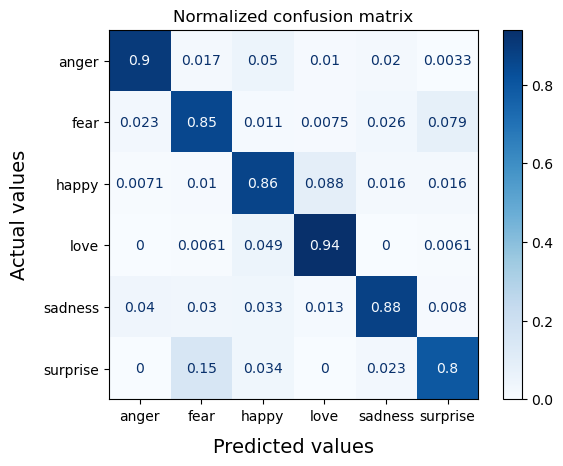

In [31]:
#Tf-idf vectorizer and class weigth
model_Evaluate(classifier_svm_linear_3, X_test_2, y_test_2)

# Ứng dụng mô hình

In [40]:
x_use = pd.read_csv("/kaggle/input/emotions-test/Emotion_test.csv",encoding="latin1")
x_ = x_use.copy()
x_use["Text"] = x_use["Text"].str.lower()
x_use["Text"] = x_use["Text"].apply(lambda text: remove_punctuation(text))
x_use["Text"] = x_use["Text"].apply(lambda text: remove_stopwords(text))
x_use['Text'] = x_use["Text"].apply(lemmatize_text)
x_use["Text"] = x_use["Text"].apply(lambda text: remove_freqwords(text))
x_use["Text"] = x_use["Text"].apply(lambda text: remove_rarewords(text))

vectorizer = TfidfVectorizer(vocabulary=TfidfVocabulary)
features = vectorizer.fit_transform(x_use["Text"])
y_use = classifier_svm_linear_3.predict(features)
decoded_labels = encoder.inverse_transform(y_use)
y_ = pd.DataFrame(decoded_labels, columns = ['Emotion'])
res = pd.concat([x_, y_], axis=1, ignore_index=True)
res.columns = ['Text', 'Emotion']
res.to_csv('emotion_test_res.csv',index=False)
pd.read_csv("/kaggle/working/emotion_test_res.csv",encoding="latin1")

Text   Emotion
0                   This news really brightens my day   sadness
1   Can't believe I fall for that stupid lie he said    sadness
2   I get into groups where I feel really awkward ...   sadness
3   I feel as if I should be punished for neglecti...   sadness
4                  Love you and always support you!!!     happy
5   I was shocked when hearing that he was gonna e...  surprise
6   I finally get the job I want since I was a chi...     happy
7   She brings so much positive energy. I can see ...     happy
8   I feel really proud of myself for accomplishin...     happy
9   I couldn't hide my disappointment when I heard...     anger
10  I couldn't contain my joy when I received her ...     happy
11  I felt a wave of nostalgia wash over me as I w...     anger
12  That was such a stupid idea I can't believe I ...   sadness
13  I secretly delighted in their surprise visit. ...     happy
14  I feel like I should be spending this precious...     happy
15  I feel violent and crazy and I feel myself slo...     anger
16  This movie really got me. I burst into tears r...   sadness
17  I have come here 3 years ago and it's still on...     happy
18  I can't believe my ears when hearing that you ...   sadness
19  This is type of news I want to see everyday. I...     happy